# GMDH with RBF - 1 Layer Implementation

This notebook implements a Group Method of Data Handling (GMDH) neural network with Radial Basis Function (RBF) kernels. The architecture consists of:
- **1 Layer GMDH**: Feature extraction using polynomial combinations
- **RBF Layer**: Final prediction using radial basis functions

## Overview
GMDH is a self-organizing neural network that automatically selects the best features through polynomial combinations. Combined with RBF, it creates a powerful regression model.


## Import Required Libraries

Import essential libraries for data manipulation, numerical operations, visualization, and preprocessing.


In [39]:
#importing essential libraries
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from IPython.display import display, clear_output

## Mount Google Drive

Mount Google Drive to access the dataset stored in the cloud storage.


In [40]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load and Prepare Dataset

Load the Lorenz time-series dataset from Excel file. Separate input features (all columns except last) and target variable (last column).


In [41]:
#reading the Dataset and drop the torget
data = pd.read_excel('/content/drive/MyDrive/Time-series/Lorenz Dataset.xlsx' ,header=None)
input = data.iloc[:,:-1].values
target = data.iloc[:,-1].values

## Check Input Shape

Display the shape of the input data to verify the dataset dimensions.


In [42]:
print(input.shape)

(1991, 9)


## Normalize Data

Normalize input and target variables separately using MinMaxScaler to scale values between 0 and 1. This ensures all features are on the same scale for better training.


In [43]:
# Create MinMaxScaler instances for input and target separately
scaler_input = MinMaxScaler(feature_range=(0, 1))
scaler_target = MinMaxScaler(feature_range=(0, 1))

# Normalize the input and target variables separately
input = scaler_input.fit_transform(input)
target = scaler_target.fit_transform(target.reshape(-1, 1))

## Split Dataset

Split the dataset into training (70%), validation (15%), and test (15%) sets for model training and evaluation.


In [44]:
total_rows = len(input)
train_size = int(0.7 * total_rows)
valid_size = int(0.15 * total_rows)
test_size = int(0.15 * total_rows)

# split the DataFrame
X_train = input[:train_size, :]
X_valid = input[train_size:train_size + valid_size, :]
X_test = input[train_size + valid_size:, :]
y_train = target[:train_size]
y_valid = target[train_size:train_size + valid_size]
y_test = target[train_size + valid_size:]

n c

In [45]:
#defining needed functions
def Choosing_pairs(arr):
    pairs = np.array([(arr[i], arr[j]) for i in range(len(arr)) for j in range(i+1, len(arr))])
    return pairs

def plot_regression_line(x, y, label):
    coefficients = np.polyfit(x, y, 1)
    polynomial = np.poly1d(coefficients)
    x_line = np.linspace(min(x), max(x), 100)
    y_line = polynomial(x_line)
    plt.plot(x_line, y_line, label=label)

def remove_neuron(weight,mses, threshold_mse):
    indexlist = []
    i = 0
    for data in mses:
      randomnumber = np.random.rand()
      if data < threshold_mse:
        indexlist.append(i)
      i+=1
    weight_copy = np.copy(weight)
    weight_copy[indexlist,:] = 0
    return weight_copy , indexlist

def GMDH(Choosing_pairs,weight):
  X = np.zeros((weight.shape[0],6))
  net = np.zeros(weight.shape[0])
  i = 0

  for pair in Choosing_pairs:
    X[i] = np.array([pair[0] ,pair[1], pair[0] * pair[0], pair[1] * pair[1], pair[1] * pair[0], 1])
    net[i] = X[i].reshape(-1,1).T.dot(weight[i])
    i+=1
  return net,X

ell 

In [46]:
n1 = 4
n2 = n1*(n1-1)//2
eta = 0.001
epoch = 150
a, b = -1, 1

output_data_train = np.zeros(train_size)
output_data_test = np.zeros(test_size)
mse_train = np.zeros(epoch)
mse_test = np.zeros(epoch)
mse_error_train = np.zeros((train_size,n2))
mse_error_vlaidation = np.zeros((valid_size,n2))
mse_error_test = np.zeros((test_size,n2))


## Train GMDH Layer 1

Train the first GMDH layer:
1. Create input pairs for all data samples
2. Initialize random weights
3. For each epoch:
   - Perform feedforward pass
   - Calculate error and update weights using backpropagation
   - Compute MSE on training and validation sets
4. The network learns polynomial combinations of input features

In [47]:
#making input for GMDH
GMDH_input = list()
for i in range(data.shape[0]):
    input_data = input[i, :4]
    GMDH_input.append(Choosing_pairs(input_data)) # 6 * 2

#Defining 1 layer GMDH
w1 = np.random.uniform(a, b, (n2, 6)) #100*3
net1 = np.zeros(n2) #100 * 1
o1 = np.zeros(n2) #100 * 1

for t in range(epoch):
    error = np.zeros((n2))

    for i in range(train_size):

      # Feedforward
        net1 , X = GMDH(GMDH_input[i] , w1)
        o1 = net1

        # Backpropagation
        target = np.full(n2, input[i, 4])
        error = target - o1 # n2*1

        for j in range(n2):
          w1[j] += eta * error[j]*X[j]


    for i in range(train_size):
        net1 , X = GMDH(GMDH_input[i] , w1)
        o1 = net1
        mse_error_train[i] = input[i, 4] - o1

    column_means = np.mean(mse_error_train**2, axis=0)
    print(f"MSE of train {t}: {column_means}")

    for i in range(valid_size):
        net1 , X = GMDH(GMDH_input[train_size+i] , w1)
        o1 = net1
        mse_error_vlaidation[i] = input[train_size+i, 4] - o1

MSE of train 0: [0.09633354 0.01028896 0.01902316 0.05317051 0.02792857 0.04500194]
MSE of train 1: [0.04861135 0.00763075 0.00683917 0.03092569 0.01618458 0.02335755]
MSE of train 2: [0.03284351 0.00707204 0.00519925 0.02024654 0.01239765 0.01565599]
MSE of train 3: [0.02264947 0.00670786 0.00415265 0.01363424 0.01004944 0.01094081]
MSE of train 4: [0.01614145 0.00644778 0.00347634 0.0094786  0.00853804 0.00796597]
MSE of train 5: [0.01199133 0.00625372 0.00303894 0.0068651  0.00755521 0.0060809 ]
MSE of train 6: [0.00933795 0.0061023  0.00275404 0.00522297 0.00690905 0.0048825 ]
MSE of train 7: [0.00763445 0.00597867 0.00256644 0.00419251 0.00647788 0.00411693]
MSE of train 8: [0.00653428 0.00587334 0.00244104 0.0035469  0.00618436 0.00362406]
MSE of train 9: [0.00581782 0.00578022 0.00235546 0.0031431  0.00597926 0.00330292]
MSE of train 10: [0.00534576 0.00569538 0.00229545 0.00289102 0.00583119 0.00308985]
MSE of train 11: [0.00502971 0.00561631 0.00225192 0.00273395 0.00572009 0.

ead 

## Prune GMDH Neurons

Remove neurons with high validation error (pruning):
- Calculate mean validation MSE for each neuron
- Remove neurons whose absolute MSE exceeds the threshold
- This reduces model complexity and prevents overfitting


In [48]:
#removing Neurons from GMDH
column_means = np.mean(mse_error_vlaidation, axis=0)
mse_validation = np.mean(np.abs(column_means), axis=0)
print(f"MSE of Validation : {column_means}")
print(f"Total absolute  Mse : {mse_validation}")
print("Old Weight Matrix : ")
print(w1)
w1_new , removed_index_list= remove_neuron(w1,np.abs(column_means), mse_validation)
print("New Weight Matrix : ")
print(w1_new)


MSE of Validation : [ 0.00099737 -0.00086205  0.0029332   0.00303018  0.00229824 -0.00010139]
Total absolute  Mse : 0.0017037388777402874
Old Weight Matrix : 
[[ 0.06389765  0.62794587  0.37488856  0.11792374 -0.22510697  0.06984769]
 [-0.42927371  0.99967847 -0.02975292 -0.25642628  0.68018537  0.09304694]
 [ 0.8504696   0.26458561 -0.16706025  0.50899277 -0.46358296 -0.02188967]
 [ 0.92682985 -0.01044757  0.31015528 -0.77557198  0.52744859  0.02080472]
 [ 0.90008637 -0.20330999  0.34668825 -0.1793008   0.10903508  0.06500771]
 [ 0.45693197  0.24839755 -0.18813288  0.34154061  0.12200056  0.06223151]]
New Weight Matrix : 
[[ 0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.        ]
 [ 0.8504696   0.26458561 -0.16706025  0.50899277 -0.46358296 -0.02188967]
 [ 0.92682985 -0.01044757  0.31015528 -0.77557198  0.52744859  0.02080472]
 [ 0.90008637 -0.20330999  0.34668825 -0.1793008   0.10903508  0.0650

## Feature Extraction - Layer 1 Output

Extract features from the trained and pruned GMDH layer:
- Pass all data through the GMDH network
- Use the output as input features for the RBF layer
- Calculate MSE on train, validation, and test sets
- Remove columns corresponding to pruned neurons

## **Feature Extraction layer 1**

## Define RBF Functions

Define Radial Basis Function (RBF) kernel and initialization:
- **rbf_kernel**: Gaussian RBF kernel function
- **initialize_parameters**: Initialize RBF centers, sigmas (widths), and bias


In [49]:
input_data1 = np.zeros((data.shape[0],w1_new.shape[0]))
for i in range(train_size):
    net1 , X = GMDH(GMDH_input[i] , w1_new)
    o1 = net1
    input_data1[i] = o1
    mse_error_train[i] = input[i, 4] - o1

column_means = np.mean(mse_error_train, axis=0)
print(f"MSE of train : {column_means}")

for i in range(valid_size):
    net1 , X = GMDH(GMDH_input[train_size+i] , w1_new)
    o1 = net1
    input_data1[i+train_size] = o1
    mse_error_vlaidation[i] = input[train_size+i, 4] - o1
column_means = np.mean(mse_error_vlaidation, axis=0)
print(f"MSE of vlaidation : {column_means}")

for i in range(test_size):
    net1 , X = GMDH(GMDH_input[train_size+valid_size+i] , w1_new)
    o1 = net1
    input_data1[i+train_size+valid_size] = o1
    mse_error_test[i] = input[train_size + valid_size + i, 4] - o1

column_means = np.mean(mse_error_test, axis=0)
print(f"MSE of test : {column_means}")
input_data1 = np.delete(input_data1,removed_index_list, axis=1)
print(input_data1.shape)

MSE of train : [4.48474286e-01 4.48474286e-01 5.24214878e-04 5.60536354e-04
 3.34189571e-04 4.48474286e-01]
MSE of vlaidation : [0.41169526 0.41169526 0.0029332  0.00303018 0.00229824 0.41169526]
MSE of test : [0.59304897 0.59304897 0.00131664 0.00329342 0.00374477 0.59304897]
(1991, 3)


## Initialize RBF Parameters

Set up RBF network:
- Number of RBF neurons
- Learning rates for weights and centers/sigmas
- Initialize weights, centers, and sigmas randomly
- Prepare arrays for storing training progress


## **RBF functions**

## Train RBF Network

Train the RBF network:
1. **Forward Pass**: Compute RBF kernel outputs and final prediction
2. **Backward Pass**: Update weights, centers, and sigmas using gradient descent
3. Calculate MSE on training and validation sets
4. Visualize training progress with real-time plots showing:
   - Actual vs Predicted values
   - MSE curves for training and validation
cell


In [50]:
# Function to calculate the Gaussian RBF kernel
def rbf_kernel(x, center, sigma):
    net = np.linalg.norm(x - center)
    return np.exp(-net**2 / (2 * sigma**2))

# Function to initialize RBF neuron centers and sigmas
def initialize_parameters(X, num_neurons, number_feature):
    centers = np.zeros((num_neurons, number_feature))
    for i in range(number_feature):
        selected_indices = np.random.choice(X.shape[0], num_neurons, replace=False)
        centers[:, i] = X[selected_indices, i]
    sigma = (X.max() - X.min()) / math.sqrt(2 * num_neurons)
    sigmas = np.ones((num_neurons, 1)) * sigma  # Initialize sigmas for each neuron
    bias = 0.0
    return centers, sigmas, bias



## Visualize Results

Create regression plots using seaborn to visualize the relationship between actual and predicted values:
- Training set regression plot
- Validation set regression plot
These plots help assess model performance and identify any systematic errors.


## **initialize variables of RBF and Create Layers of RBF**

In [51]:
num_neurons = 5
learning_rate = 0.01
learning_rate_a = 0.001
epochs = 200

# Random initialization
rbf_weights = np.random.uniform(-1, 1, (num_neurons, 1))
o_rbf = np.zeros((num_neurons, 1))
number_feature = X_train.shape[1]

# Reshape y_train to have two dimensions
y_train = y_train.reshape(-1, 1)

# Initialize parameters
centers, sigmas, bias = initialize_parameters(X_train, num_neurons, number_feature)
mse_error_train_rbf = np.zeros(X_train.shape[0])
mse_error_valid_rbf = np.zeros(X_valid.shape[0])
output_data_train = np.zeros(train_size)
output_data_valid = np.zeros(valid_size)
mse_train = np.zeros(epochs)
mse_valid = np.zeros(epochs)

## **Feedforward and BackPropagation RBF**

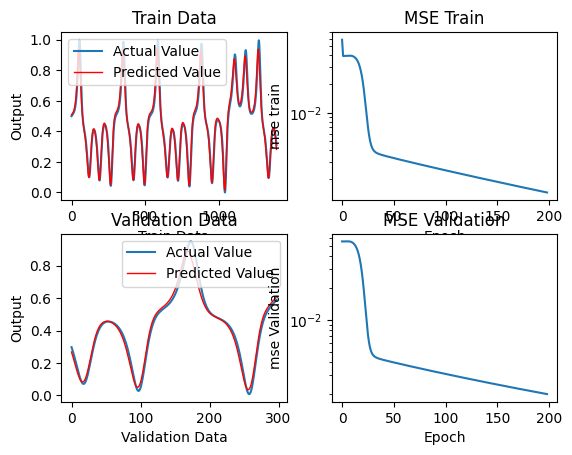

In [52]:
for t in range(epochs):
  for i in range(X_train.shape[0]):
      # Forward pass
      hidden_layer_output = np.array([rbf_kernel(X_train[i], c, sigma) for c, sigma in zip(centers, sigmas)])
      output = np.dot(hidden_layer_output, rbf_weights.T)[0][0] + bias
      # Backward pass (Gradient Descent)
      error_rbf = y_train[i][0] - output
      rbf_weights += learning_rate * error_rbf * hidden_layer_output
      bias += learning_rate * error_rbf

      for j in range(num_neurons):
        centers[j] += learning_rate_a * error_rbf * rbf_weights.T.dot(hidden_layer_output)[0][0]*(X_train[i]-centers[j]) * (1/(sigmas[j][0]**2))
        sigmas[j] += learning_rate_a * error_rbf * rbf_weights.T.dot(hidden_layer_output)[0][0]*(np.linalg.norm(X_train[i]-centers[j])**2)*(1/(sigmas[j][0]**3))

      output_data_train[i] = output
      mse_error_train_rbf[i] = y_train[i][0] - output



  for i in range(X_valid.shape[0]):
      # Forward pass
      hidden_layer_output = np.array([rbf_kernel(X_valid[i], c, sigma) for c, sigma in zip(centers, sigmas)])
      output = np.dot(hidden_layer_output, rbf_weights.T)[0][0] + bias
      output_data_valid[i] = output
      mse_error_valid_rbf[i] = y_valid[i] - output

  mse_train[t] = np.mean(mse_error_train_rbf**2)
  mse_valid[t] = np.mean(mse_error_valid_rbf**2)

plt.subplot(2, 2, 1)
plt.cla()  # Clear the previous plot
plt.plot(input[:train_size, 4], label="Actual Value")
plt.plot(output_data_train, 'r', linewidth=1, label="Predicted Value")
plt.legend()
plt.title('Train Data')
plt.xlabel('Train Data')
plt.ylabel('Output')

# The MSE train data plot
plt.subplot(2, 2, 2)
plt.cla()
plt.semilogy(mse_train[:t])
plt.title('MSE Train')
plt.xlabel('Epoch')
plt.ylabel('mse train')

# The valid data plot
plt.subplot(2, 2, 3)
plt.cla()
plt.plot(input[train_size:train_size + valid_size,4], label="Actual Value")
plt.plot(output_data_valid, 'r', linewidth=1, label="Predicted Value")
plt.legend()
plt.title('Validation Data')
plt.xlabel('Validation Data')
plt.ylabel('Output')

# MSE valid data plot
plt.subplot(2, 2, 4)
plt.cla()
plt.semilogy(mse_valid[:t])
plt.title('MSE Validation')
plt.xlabel('Epoch')
plt.ylabel('mse Validation')

display(plt.gcf())
clear_output(wait=True)


plt.show()

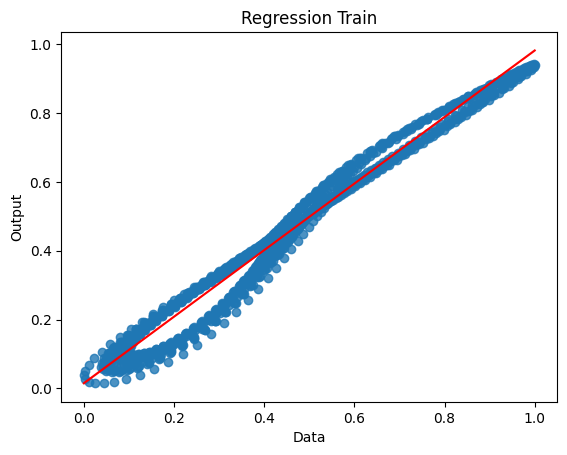

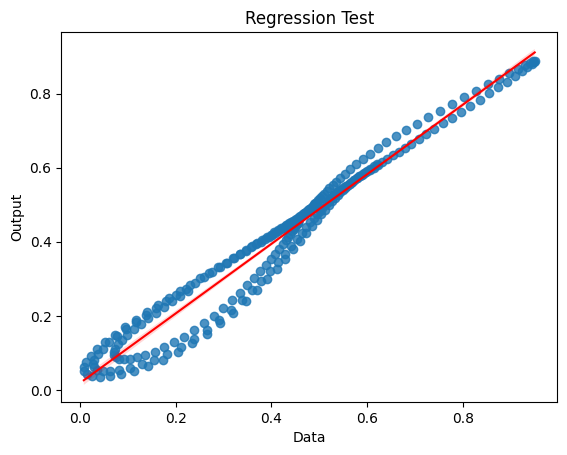

In [54]:
import seaborn as sns
# Create a scatter plot with a regression line
plt.figure(2)
sns.regplot(x=y_train, y=output_data_train, line_kws={"linewidth": 1.5, "color": "red"})
plt.title('Regression Train')
plt.xlabel('Data')
plt.ylabel('Output')

plt.show()  # Show the plot

# Create a scatter plot with a regression line
plt.figure(3)
sns.regplot(x=y_valid, y=output_data_valid, line_kws={"linewidth": 1.5, "color": "red"})
plt.title('Regression Test')
plt.xlabel('Data')
plt.ylabel('Output')

plt.show()  # Show the plot